# Applied Project - Patient Survival Prediction

**Gali Levin 207118647 , Talia Meiri 311227565**

# Imports

In [146]:
!pip install shap
!pip install fastcluster


In [186]:
# Basic imports for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
from math import sqrt

# Machine Learning preprocessing and evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_predict, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report,accuracy_score, roc_auc_score, roc_curve , silhouette_score, mean_squared_error, r2_score, mean_absolute_error, max_error, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import sklearn

# Specific model import
import xgboost as xgb

# Imbalanced dataset handling
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Advanced dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# Model explanability
import shap
import fastcluster

from collections import defaultdict
import os
import ipywidgets as widgets
from IPython.display import display
import joblib

In [187]:
# reading data
Data = "dataset.csv"
df = pd.read_csv(Data)

In [188]:
# Drop unrelevant columns
columns_to_drop = ['encounter_id', 'patient_id', 'icu_id', 'Unnamed: 83']
df = df.drop(columns=columns_to_drop)

# Drop rows with null values in the target feature (hospital_death)
df = df.dropna(subset=['hospital_death'])

# Split target values from other features
X = df.drop(columns=['hospital_death'])
y = df['hospital_death']

In [189]:
columns = X.columns
categorical_columns = ['hospital_id','ethnicity', 'icu_admit_source', 'icu_type', 'icu_stay_type', 'gcs_eyes_apache', 'gcs_motor_apache',
                       'gcs_verbal_apache', 'apache_3j_bodysystem', 'apache_2_bodysystem']
binary_columns = ['elective_surgery', 'gender', 'apache_post_operative',  'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache',
                  'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']
numeric_columns =  [col for col in X.columns if col not in categorical_columns + binary_columns]

# Outliers

Outliers can significantly affect the performance of the machine learning model. They can distort the overall distribution of the data, leading to biased model estimates and poor generalization to new data.

Let's examine the distribution of our numeric feature values using box plots.

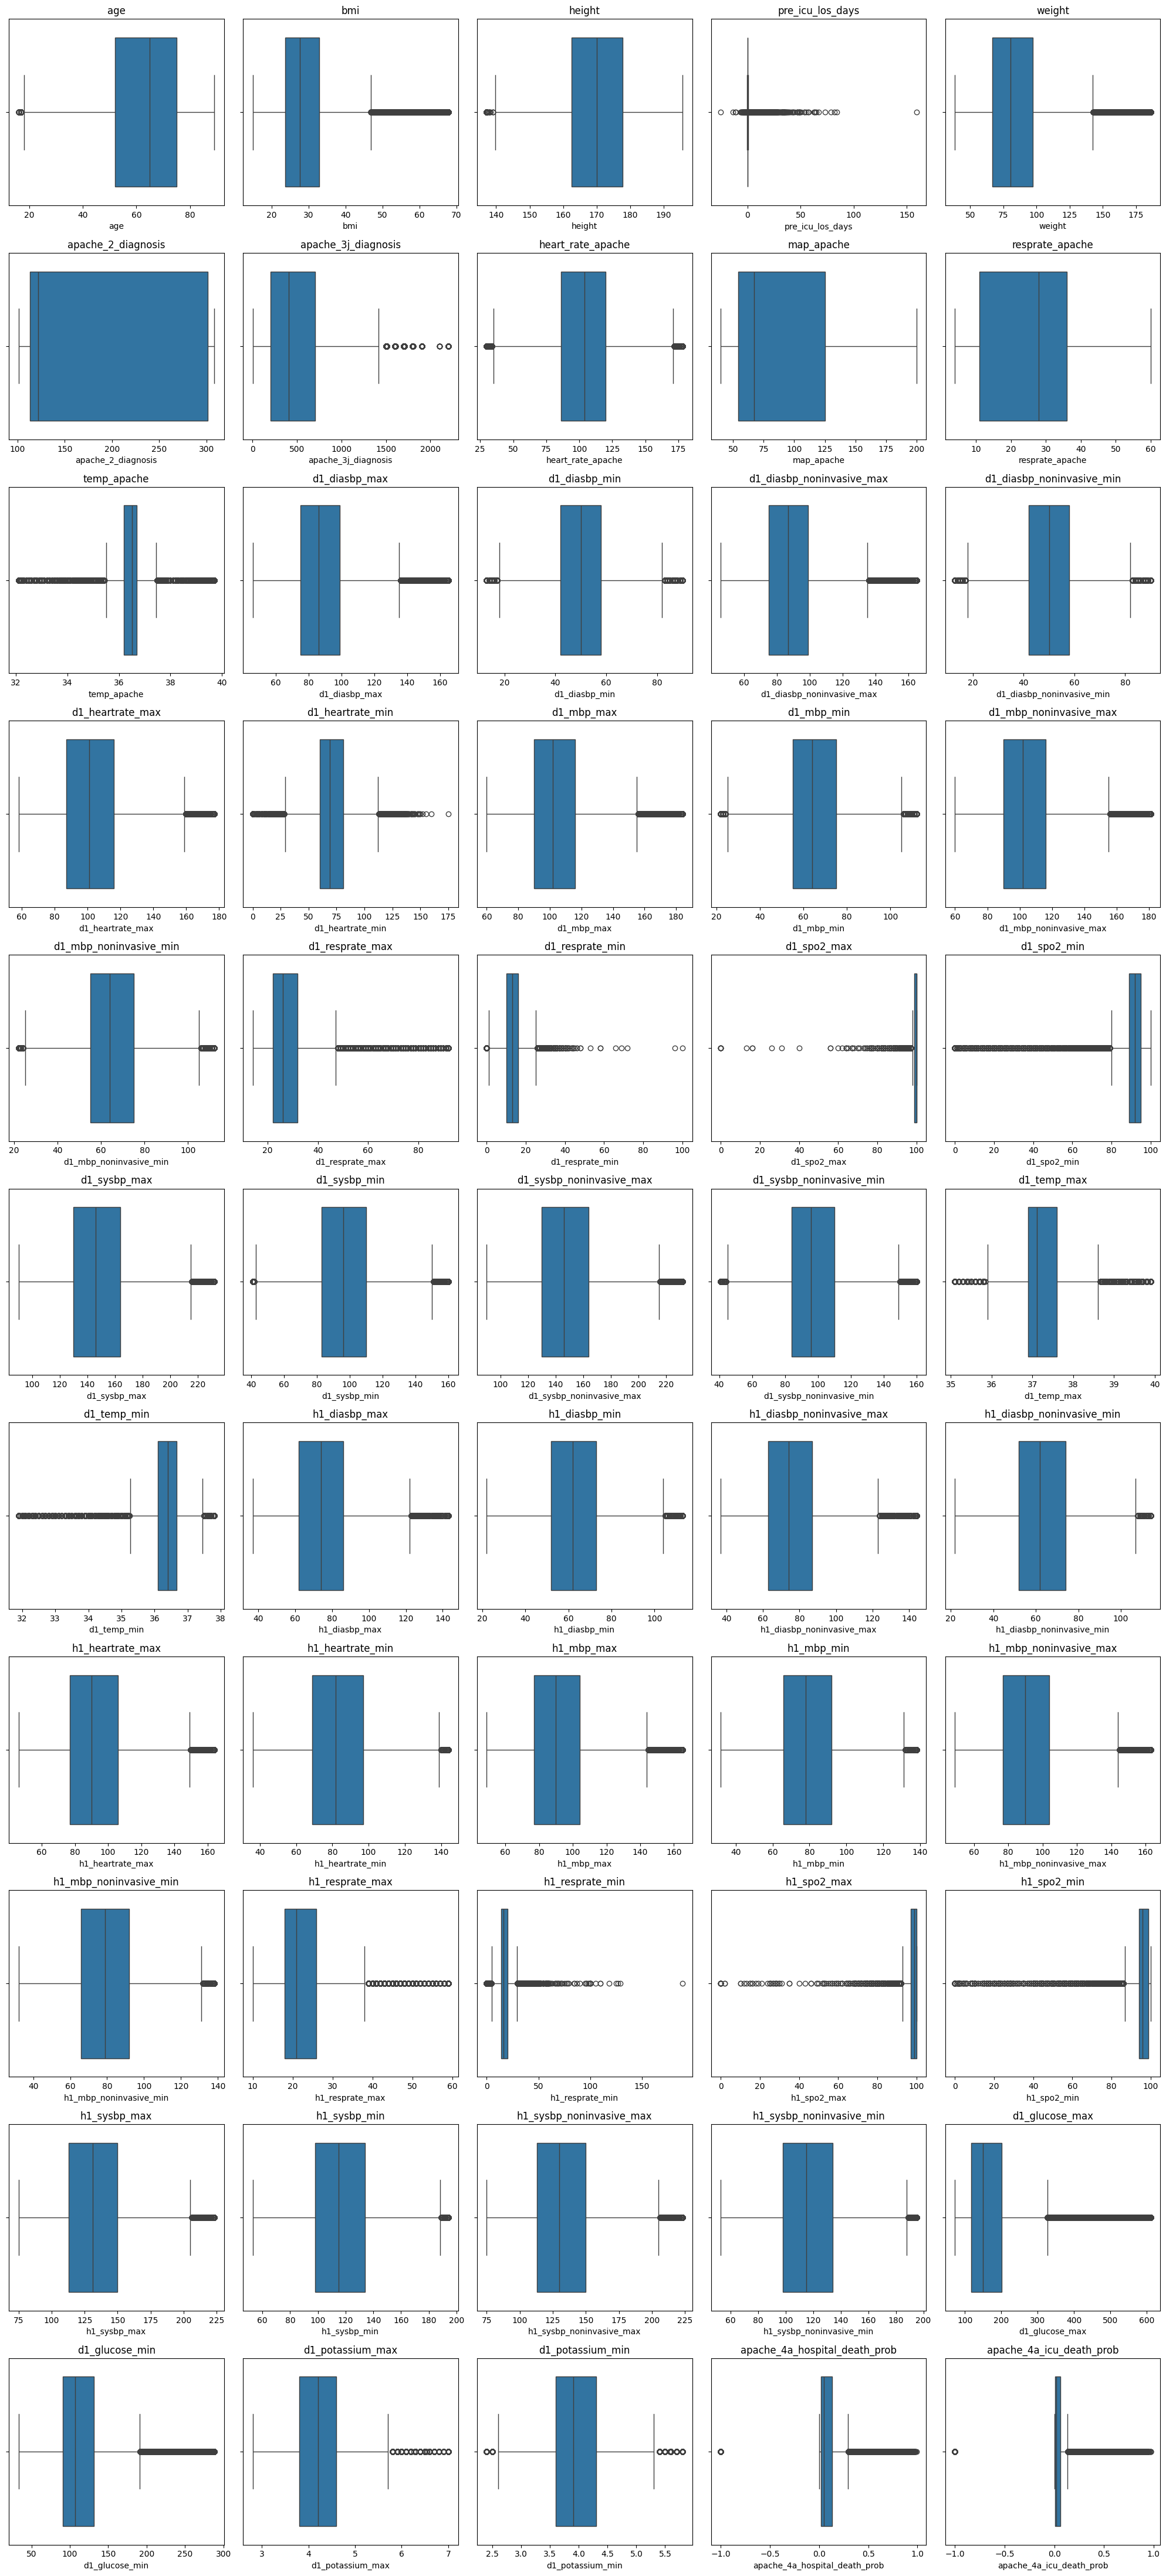

In [190]:
# Setting the number of columns in the grid of subplots
ncols = 5
# Calculating the required number of rows based on the number of numerical columns
nrows = (len(numeric_columns) + ncols - 1) // ncols

# Setting the size of the entire figure (width, height in inches)
plt.figure(figsize=(ncols * 4, nrows * 4))

for i, col in enumerate(numeric_columns):
    # Adding a subplot for each numerical column
    plt.subplot(nrows, ncols, i + 1)
    # Using seaborn to create the boxplot
    sns.boxplot(x=X[col])
    plt.title(col)

plt.tight_layout()
plt.show()

As we can see, there is an outliers problem in all the features and there are many features to address.
We suspect that several features in our dataset exhibit significant skewness (there is a long tail), therefore we may have outliers. Let's start by visualizing these distributions.

# Skewness

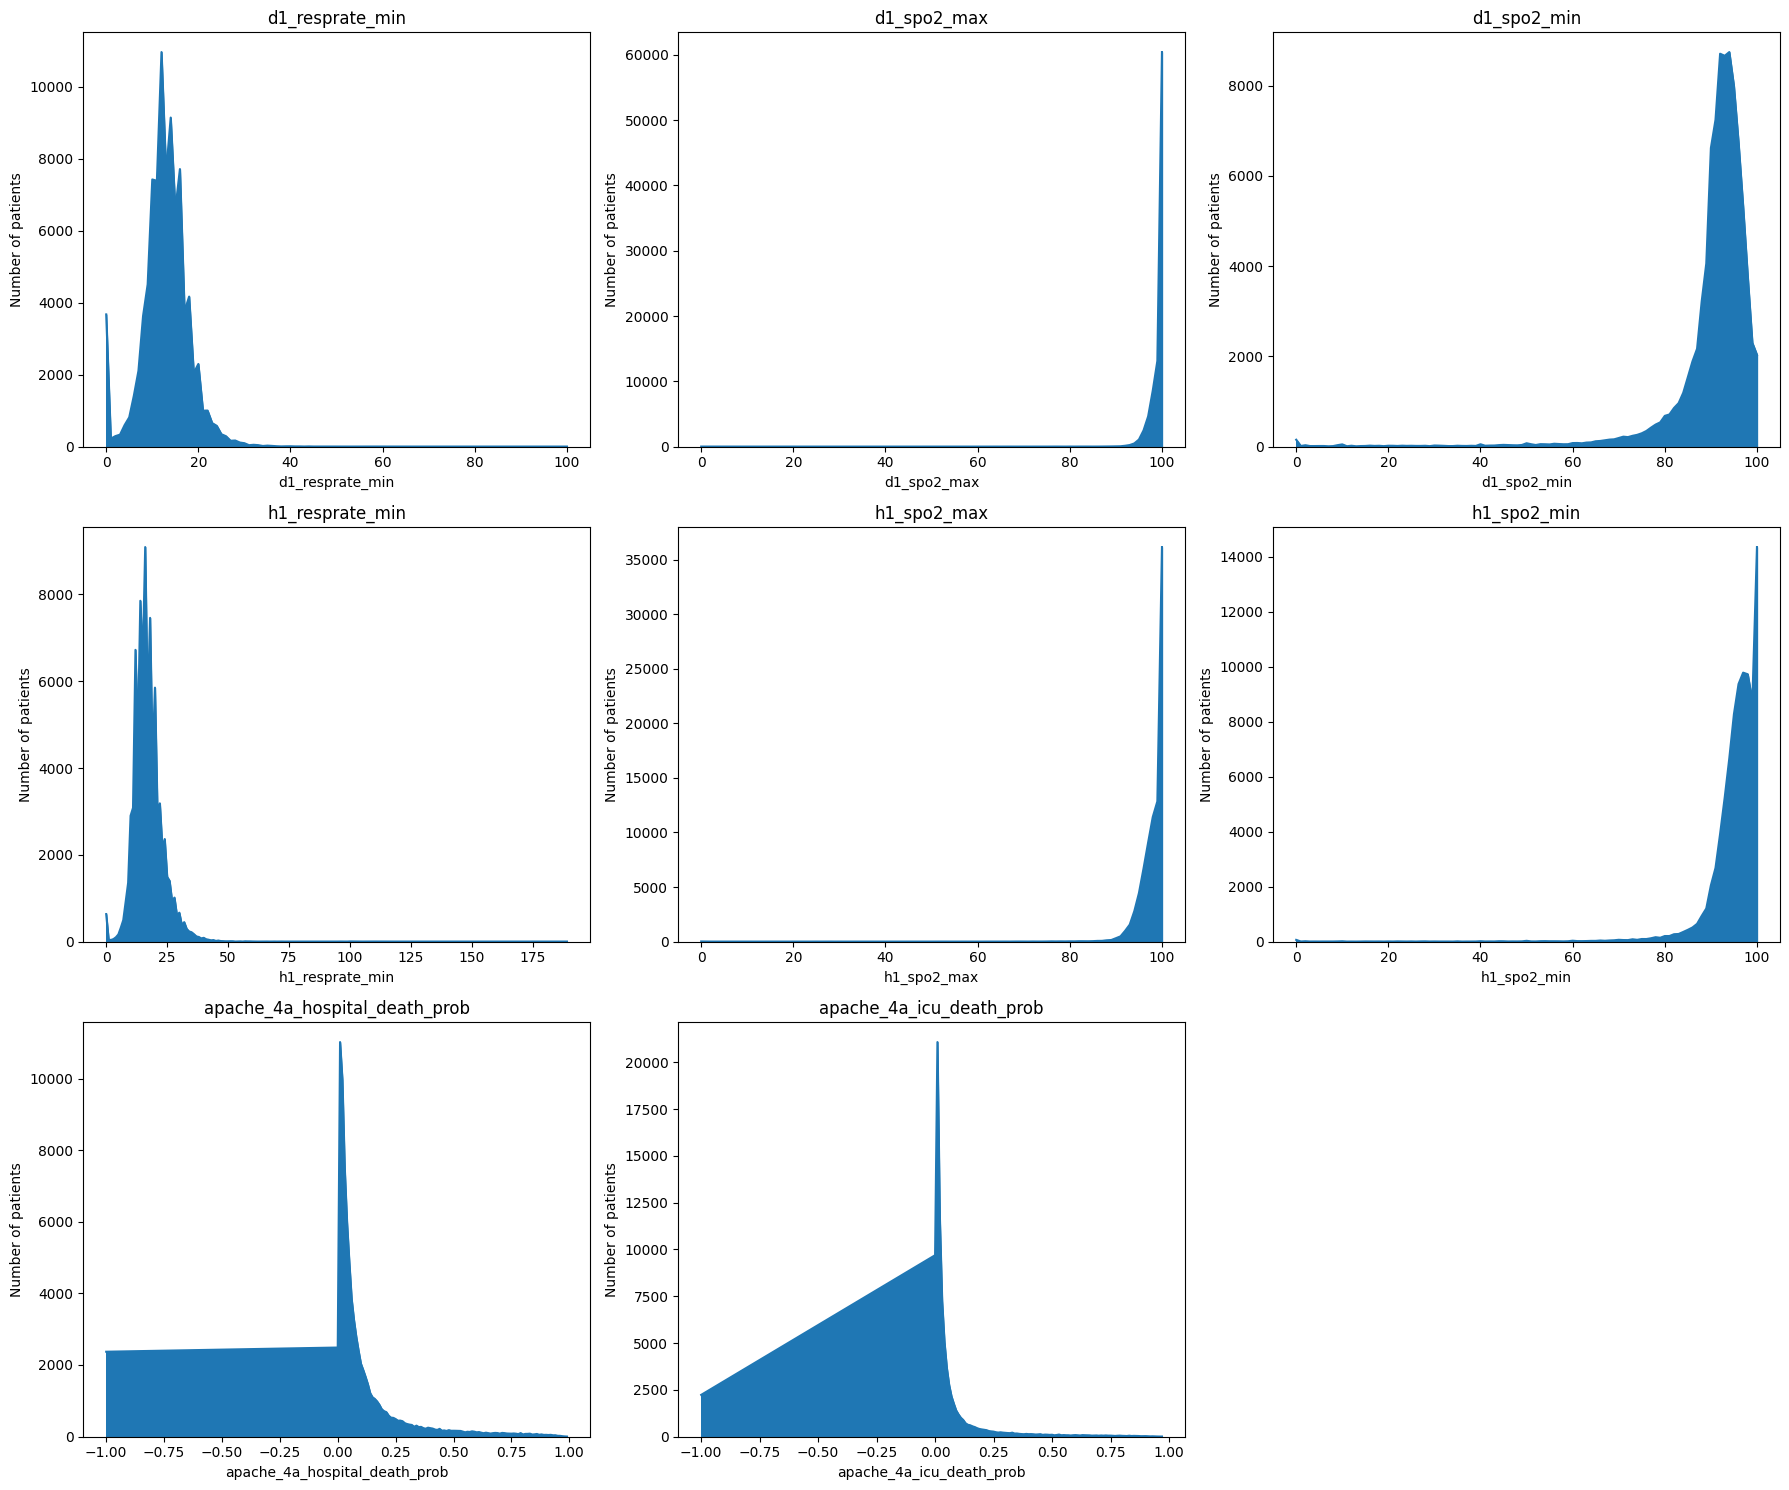

In [191]:
def plot_feature_distributions(dataframe, features, cols=3):
    # Number of features determines the number of rows and columns in the grid
    nrows = int(np.ceil(len(features) / cols))

    # Create a figure with subplots in a grid defined by nrows and cols
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(cols * 6, nrows * 5))

    # Flatten axes array for easy iteration in case of one row or column
    axes = axes.flatten()

    # Loop through the features and create an area plot for each one
    for i, feature in enumerate(features):
        # Plot the value counts as an area plot, sorted by the index, on respective subplot
        dataframe[feature].value_counts().sort_index().plot.area(ax=axes[i], title=feature)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Number of patients')

    # If there are more subplots than features, turn off the extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

selected_features = ['d1_resprate_min','d1_spo2_max', 'd1_spo2_min', 'h1_resprate_min', 'h1_spo2_max', 'h1_spo2_min', 'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']
plot_feature_distributions(X, selected_features)

As observed, the data is highly skewed and not uniformly distributed. We will determine how to address this issue later.

# Examining the target feature - Imbalance of the target: 'hospital_death'

Amount of two classe in 'hospital death': 
 hospital_death
0    83798
1     7915
Name: count, dtype: int64 




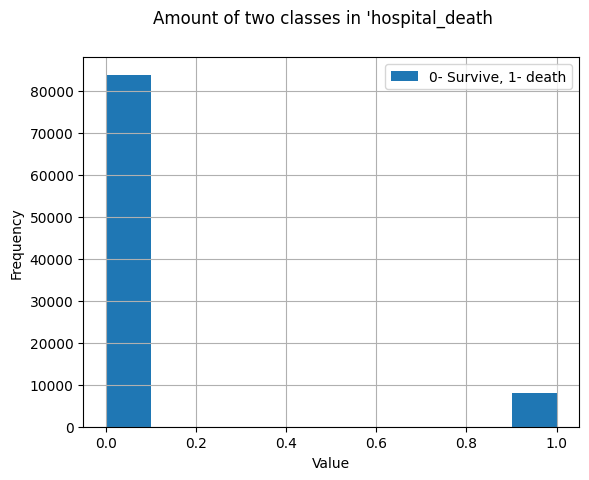

In [192]:
# Imbalance of the target: 'hospital_death'
Data_count = y.value_counts()
print(f"Amount of two classe in 'hospital death': \n {Data_count} \n\n")

# Visualize two classes in 'hospital_death'
Data_hist = y.hist()
plt.suptitle("Amount of two classes in 'hospital_death")
plt.xlabel("Value")
plt.ylabel("Frequency")
Data_hist.legend(["0- Survive, 1- death"])


In [193]:
# calculating proportion between control values and case values
print(f"Proportion of two classe in 'hospital death': {Data_count[0]/Data_count[1]}")

Proportion of two classe in 'hospital death': 10.587239418825016


We can see that the target feature- hospital death is highly unbalanassed. It might impact the model performings or biased the results. We will need to dell with that, and to consider to balance the data with difference methods in order to get reliable results.

# Examining Correlations to the target feature

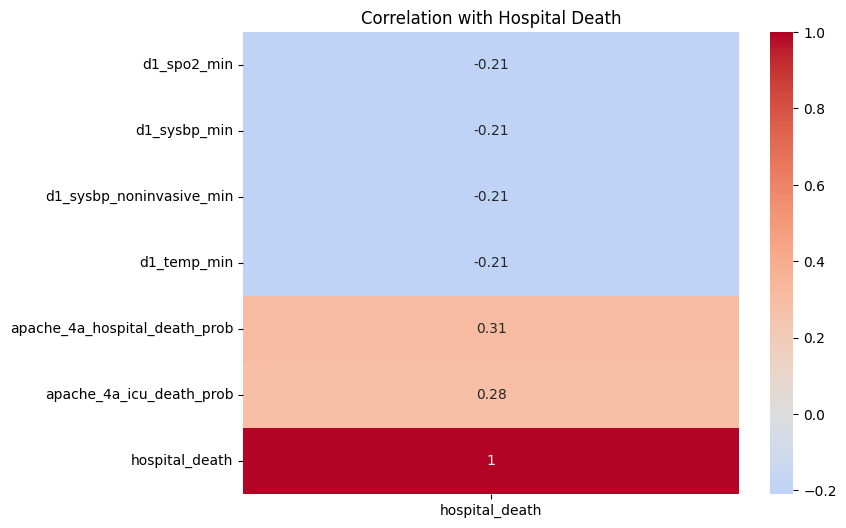

In [194]:
# Concatenate X_train and y_train for correlation calculation
data = pd.concat([X[numeric_columns], y], axis=1)

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Filter the correlation matrix to only show features with correlation to 'hospital_death' <= -0.2 or >= 0.2
target_correlation = correlation_matrix.loc[:, ['hospital_death']]
significant_correlations = target_correlation[(target_correlation['hospital_death'] <= -0.2) | (target_correlation['hospital_death'] >= 0.2)]

# Plotting the significant correlations
plt.figure(figsize=(8, 6))
sns.heatmap(significant_correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation with Hospital Death')
plt.show()

The above figure displays a correlation matrix that highlights only the features which have a correlation coefficient of less than -0.2 or greater than 0.2 with the target feature 'hospital death'.

As expected, 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' are highly correlated with the target variable, as both are estimates of death probabilities.

Excluding them from the model might not be the best decision given their potential contribution to predictive accuracy, which corresponds to their high correlation.

We will test their importance to model prediction and performance, and decide accordingly whether to remove them.

# Interaction between age, gender, and hospital death

In [195]:
# Set y_train an appropriate name for merging
y_train_named = y.rename('hospital_death')

# Merge X_train with y_train using the index
X_train_with_target = X.join(y_train_named)

# creating histogram of interaction between age, gender, and the target feature
fig = px.histogram(X_train_with_target[['age', 'gender', 'hospital_death']].dropna(), x= "age", y = "hospital_death", color = 'gender',
                  marginal = 'box', title= "Interaction between age, gender, and hospital death")


fig.show()

We examine the impact of the gender feature, the age feature, and the interaction between both, on the target value.
We can relate to the following insights:
1. It seems that Woman has lowest hospital survival rate than men.
2. It seems that between the age of 50 and 60, the hospital survival rate begin to drop.
3. It seems that for woman, the affect of age on the surviving rate is starting at the age of 50, and along men at the age of 60.

# Data Preprocessing

To ensure that the machine learning pipeline avoids data leakage and maintains the integrity of the training and testing processes, we start with spliting the data into training and test sets before undertaking any kind of data preprocessing, such as imputation, normalization, or encoding.

In [196]:
# dividing the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Handling missing values, encoding the categorical and binary features and normalized the values in the numerical features.

In [197]:
# Defining Pre-processor pipeline
preprocessor = ColumnTransformer(transformers=[
    ('numeric', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),        # Handling missing values
        ('scaler', StandardScaler())                          # Normalizing numeric columns
    ]), numeric_columns),
    ('categorical', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling missing values
        ('encoder', OneHotEncoder(handle_unknown='ignore'))   # Encoding categorical columns
    ]), categorical_columns),
    ('binary', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handling missing values
        ('encoder', OrdinalEncoder())                        # Encoding binary columns
    ]), binary_columns)
],
    remainder='passthrough'  # Keep any columns not explicitly specified in the transformers
)

# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Getting column names
new_columns = preprocessor.get_feature_names_out()

In [198]:
# Getting the feature shape after one hot encoder
print(X_train_transformed.shape)

(73370, 275)


After applying one-hot encoding,  the dimensions have increased even further.

We will need to perform feature selection and dimensionality reduction later.

# A Baseline XGBoost Model



In [199]:
# defining model
model = xgb.XGBClassifier(random_state=42)

# Define evaluation metrics
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'explained_variance']

In [200]:
def run_10_cross_validation(model, X_train_transformed, y_train, scoring):
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    results = cross_validate(model, X_train_transformed, y_train, cv=cv, scoring=scoring, return_estimator=True, return_train_score=False)
    # Cross-validated predictions on the training set
    y_train_pred_proba = cross_val_predict(model, X_train_transformed, y_train, cv=cv, method='predict_proba')[:, 1]
    y_train_pred = (y_train_pred_proba >= 0.5).astype(int)
    return results, y_train_pred_proba, y_train_pred

def get_the_best_model(results):
    # Identify the best model based on the mean ROC AUC scores
    best_model_idx = np.argmax(results['test_roc_auc'])  # Use ROC AUC to determine the best model
    return results['estimator'][best_model_idx]

def evaluate_results(results):
    print("Cross-validation results:")

    # Print the mean and standard deviation of each evaluation metric
    for metric in scoring:
        mean_score = np.mean(results[f'test_{metric}'])
        std_score = np.std(results[f'test_{metric}'])
        print(f"{metric.capitalize()} : {mean_score:.4f} (+/- {std_score:.4f})")

def plot_roc_curve_test(y_true_test, y_pred_test):
    auc_score_test = roc_auc_score(y_test, y_pred_test)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
    print(f"ROC AUC test: {auc_score_test:.4f}")

    # Visualization
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test, tpr_test, label='ROC Curve (AUC = {:.2f})'.format(auc_score_test))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve- test')
    plt.legend()
    plt.grid(True)
    plt.show()

Cross-validation results:
Accuracy : 0.9273 (+/- 0.0019)
Precision : 0.6531 (+/- 0.0204)
Recall : 0.3344 (+/- 0.0153)
F1 : 0.4421 (+/- 0.0152)
Roc_auc : 0.8850 (+/- 0.0061)
Explained_variance : 0.0994 (+/- 0.0198)
ROC AUC test: 0.8872


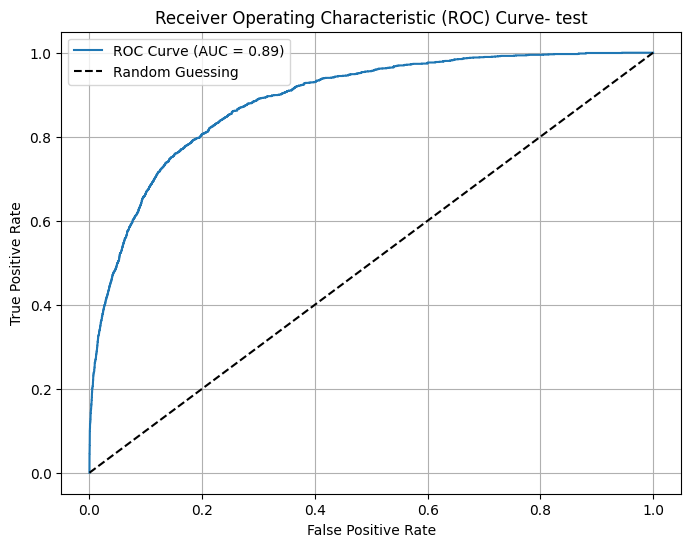

In [201]:
# Run the 10-fold cross-validation
results, y_train_pred_proba, y_train_pred = run_10_cross_validation(model, X_train_transformed, y_train, scoring)

# Evaluate and print the cross-validation results
evaluate_results(results)

# Retrieve the best model from the results
best_model = get_the_best_model(results)

# Predictions on the validation/test set
y_test_pred = best_model.predict(X_test_transformed)
y_test_pred_proba = best_model.predict_proba(X_test_transformed)[:, 1]

# Plot ROC curve
plot_roc_curve_test(y_test, y_test_pred_proba)


We decided to evaluate our initial model and terminate model performance using AUC scoring method, as it particularly powerful method for evaluating classifiers on imbalanced and skewed datasets due to its insensitivity to class distribution. In addition, we use other common classification scores to evaluate the improvement in the model performance during out tries to create a better pypline.

We can see that we have nice results by the xgboost model (after a only basic pre-processing).
From the exploration data pare, we learn that:
1. The data is highly imbalance.
2. We have a lot of ouliers values in the numeric features.
3. We have a large amount of features, increased with the pre-processing that includes one-hot-encoding.
We will need to handle those issues in the next step, in order to improve the results of the model and make sure it reliable.

# **Improving the basic pipeline**

The clinical/medical data we worked on was particularly complex and challenging for several reasons.

First, due to its large size and the extensive number of dimensions involved. High-dimensional data poses unique challenges in terms of analysis and interpretation.

Second, the complexity of the features and their non-uniform distribution, often exhibiting significant skewness.

Third, the dataset was highly imbalanced.

 These factors primarily contributed to substantial computational complexity.

Our main efforts in developing the model were focused on research and review of relevant literature to identify the most effective machine learning techniques and pipelines for managing the intricacies of our data.

We implemented advanced feature selection and dimensionality reduction methods to construct a robust model.

The pipline we developed to improve model performance:
1. Handeling outliers
2. Error Analyzing-
- Handling False alarm Vs misses rate
- Detect problematic features
- Detect problematic samples
- Feature importance analyzing
3. Feature selection
4. Trying dimention reduction
5. Fixing Imbalance in data
6. Trying another models
7. Hyper-parameters tuning



# 1- Handeling Outliers

We decided first to handle the outliers in the data, so that extreme outliers, that we do not find a jastification for their exception, won't affect the following process.

In [202]:
print("Original DataFrame shape:", X_train.shape)

# Initialize a counter for outliers
outliers_count = 0

# Define the columns to include specifically for outlier handling
include_columns = ['h1_sysbp_max', 'h1_sysbp_min', 'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
                   'h1_heartrate_max', 'h1_heartrate_min', 'h1_mbp_max', 'h1_mbp_min',
                   'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min', 'h1_diasbp_max',
                   'h1_diasbp_min', 'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min']

# Applying IQR method for outlier handling
for col in include_columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the cutoffs for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace values beyond the IQR with NaN or with the upper/lower bounds
    # Here we replace with NaN and later impute these NaNs with the median of the column
    original_train_col_data = X_train[col].copy()  # Copy original data for comparison
    X_train.loc[X_train[col] < lower_bound, col] = np.nan
    X_train.loc[X_train[col] > upper_bound, col] = np.nan

    # Count how many values were modified
    outliers_count += (original_train_col_data < lower_bound).sum()
    outliers_count += (original_train_col_data > upper_bound).sum()

# After handling outliers, you can choose to impute the NaNs created
# For example, imputing with median:
imputer = SimpleImputer(strategy='median')
X_train[include_columns] = imputer.fit_transform(X_train[include_columns])

print("Filtered DataFrame shape after handling outliers:", X_train.shape)
print(f'Number of outliers modified: {outliers_count}')

Original DataFrame shape: (73370, 80)
Filtered DataFrame shape after handling outliers: (73370, 80)
Number of outliers modified: 11861


As shown in the outlier analysis earlier in the report, we are dealing with skewed data characterized by numerous outliers.

Given the nature of the clinical data under analysis, it is crucial to approach outlier handling with caution.

This is because some clinical features inherently contain valid extreme values that are essential for accurate predictions.
Capturing and analyzing extreme fluctuations in vital signs is vital for early intervention and predicting critical.
For these reasons, we have decided to exclude features related to medical settings from outlier deletion.

We adopted the Interquartile Range (IQR) method for outlier management because it is recognized as a moderately aggressive approach, particularly effective for datasets exhibiting skewed distributions, similar to our data. This method was chosen because it robustly identifies outliers based on the quartile spread, which adjusts to the asymmetry of the data distribution.

For the outlier handling process, we strategically selected only certain features that demonstrated significant variability upon visual inspection of their distributions. This targeted approach ensures that our outlier management is both effective and preserves the integrity of critical data characteristics.

[citation:
Qiao, H., Chen, Y., Qian, C. et al. Clinical data mining: challenges, opportunities, and recommendations for translational applications. J Transl Med 22, 185 (2024). https://doi.org/10.1186/s12967-024-05005-0 ]

[citation:
Yoon JH, Jeanselme V, Dubrawski A, Hravnak M, Pinsky MR, Clermont G. Prediction of hypotension events with physiologic vital sign signatures in the intensive care unit. Crit Care. 2020 Nov 25;24(1):661. doi: 10.1186/s13054-020-03379-3. PMID: 33234161; PMCID: PMC7687996.]

**Applying the preprocessor again after deleting the outliers:**

In [203]:
# Apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Getting columns names
new_columns = preprocessor.get_feature_names_out()

In [204]:
# Evaluate the model's predictive results in a 10 fold cross-validation process after applying outlier handling
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'explained_variance']
cv_results = cross_validate(model, X_train_transformed, y_train, cv=cv, scoring=scoring)

for metric in scoring:
    mean_score = np.mean(cv_results[f'test_{metric}'])
    std_score = np.std(cv_results[f'test_{metric}'])
    print(f"{metric.capitalize()} : {mean_score:.4f} (+/- {std_score:.4f})")

Accuracy : 0.9280 (+/- 0.0024)
Precision : 0.6595 (+/- 0.0256)
Recall : 0.3406 (+/- 0.0225)
F1 : 0.4489 (+/- 0.0240)
Roc_auc : 0.8849 (+/- 0.0059)
Explained_variance : 0.1081 (+/- 0.0303)


After removing the selected outliers and running a 10-fold cross-validation check, we can see our model performance remained approximitaly the same. We will try to invastigate our data characteristic to try and precise the predictions.

# 2- Error analyzing

## Detect how many False alarm Vs misses our model predicted

Since our data is medical, we might prefer our model to increace the false alarm rate rather than the misses mistakes rates. The reason is that the "price" for predicting that a person will survive, can be less efective treatment, and if his chances in reality to survive are not so good, it can be dangerus.

4609     False
75674    False
84022    False
38035    False
24371    False
         ...  
6265     False
54886    False
76820    False
860      False
15795    False
Name: hospital_death, Length: 73370, dtype: bool


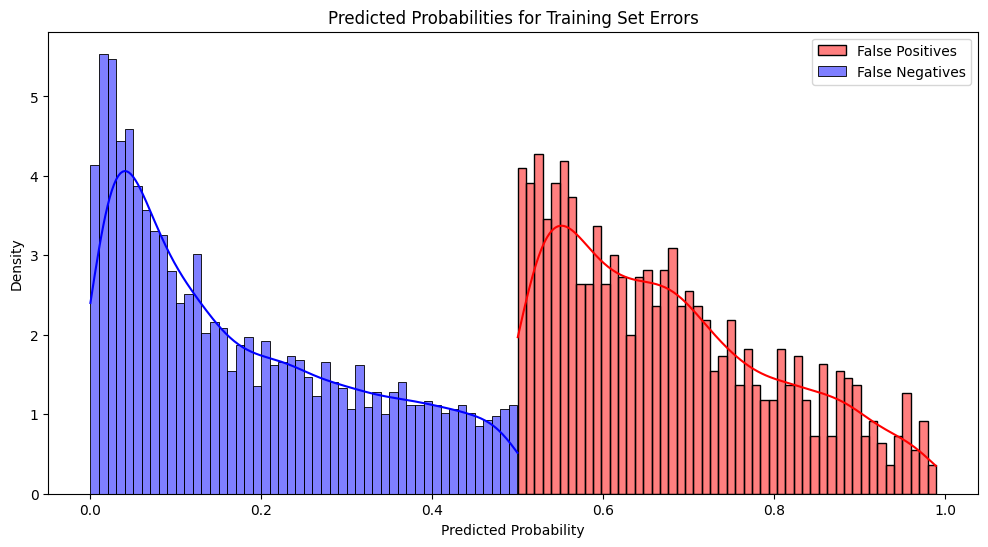

In [205]:
# Calculate errors for the training set
errors_train = (y_train_pred != y_train)
false_positives_train = (y_train_pred == 1) & (y_train == 0)
false_negatives_train = (y_train_pred == 0) & (y_train == 1)

print(false_positives_train)

# Create DataFrame for training set errors
train_errors_df = pd.DataFrame(X_train_transformed[errors_train])
train_errors_df['True_Label'] = y_train[errors_train]
train_errors_df['Predicted_Label'] = y_train_pred[errors_train]
train_errors_df['Probability'] = y_train_pred_proba[errors_train]
train_errors_df['Error_Type'] = ['False Positive' if fp else 'False Negative' for fp in false_positives_train[errors_train]]

# Visualization
plt.figure(figsize=(12, 6))
sns.histplot(train_errors_df[train_errors_df['Error_Type'] == 'False Positive']['Probability'], color='r', label='False Positives', kde=True, stat='density', bins=50)
sns.histplot(train_errors_df[train_errors_df['Error_Type'] == 'False Negative']['Probability'], color='b', label='False Negatives', kde=True, stat='density', bins=50)
plt.title('Predicted Probabilities for Training Set Errors')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


Here, the red Histogram (False Positives), represents the distribution of predicted probabilities for samples that were falsely predicted as positive (the model predicted class '1' but the true label was '0').

The blue Histogram (False Negatives), represents the distribution of predicted probabilities for samples that were falsely predicted as negative (the model predicted class '0' but the true label was '1').

In [206]:
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()

# Calculate False Alarm Rate (False Positive Rate)
false_alarm_rate = fp / (tn + fp)

# Calculate Miss Rate (False Negative Rate)
miss_rate = fn / (fn + tp)

# Expressing preference for false alarms over misses
print(f"Relative amount of False Alarms (False Positive Rate): {false_alarm_rate}")
print(f"Relative amount of Misses (False Negative Rate): {miss_rate}")
if false_alarm_rate >= miss_rate:
  print("There are more False Alarms (False Positive Rate) than Misses (False Negative Rate)")
else:
  print("There are more Misses (False Negative Rate) than False Alarms (False Positive Rate)")



Relative amount of False Alarms (False Positive Rate): 0.016765609617851496
Relative amount of Misses (False Negative Rate): 0.6656131479140329
There are more Misses (False Negative Rate) than False Alarms (False Positive Rate)


We can see the rate of "Misses" is much higher than the rate of "False alarm".

We will try to set a lower decision treshold for classification, to increase the probability to classify more instances as positive and decrease the amount of misses.

In [207]:
# Define parameters
adjusted_treshold = 0.3

def evaluate_model_with_threshold(model, X, y, cv, treshold=0.5):
    # Cross-validated predictions
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
    y_pred = (y_pred_proba >= treshold).astype(int)

    # Evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_proba)
    conf_matrix = confusion_matrix(y, y_pred)

    # Print original model evaluation
    print(f"Model Evaluation (Threshold = {treshold}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
    # Calculate False Alarm Rate (False Positive Rate)
    false_alarm_rate = fp / (tn + fp)
    # Calculate Miss Rate (False Negative Rate)
    miss_rate = fn / (fn + tp)
    # Expressing preference for false alarms over misses
    print(f"Relative amount of False Alarms (False Positive Rate): {false_alarm_rate}")
    print(f"Relative amount of Misses (False Negative Rate): {miss_rate}")

    return accuracy, precision, recall, f1, auc, conf_matrix

# Evaluate the original model (threshold = 0.5)
original_accuracy, original_precision, original_recall, original_f1, original_auc, original_conf_matrix = evaluate_model_with_threshold(model, X_train_transformed, y_train, cv, treshold=0.5)

print("\n")
# Evaluate the adjusted model (lower threshold for more false alarms)
adjusted_accuracy, adjusted_precision, adjusted_recall, adjusted_f1, adjusted_auc, adjusted_conf_matrix = evaluate_model_with_threshold(model, X_train_transformed, y_train, cv, treshold=adjusted_treshold)


Model Evaluation (Threshold = 0.5):
Accuracy: 0.9280
Precision: 0.6596
Recall: 0.3405
F1 Score: 0.4492
AUC: 0.8848
Confusion Matrix:
[[65930  1112]
 [ 4173  2155]]
Relative amount of False Alarms (False Positive Rate): 0.016586617344351302
Relative amount of Misses (False Negative Rate): 0.6594500632111252


Model Evaluation (Threshold = 0.3):
Accuracy: 0.9164
Precision: 0.5164
Recall: 0.4796
F1 Score: 0.4973
AUC: 0.8848
Confusion Matrix:
[[64200  2842]
 [ 3293  3035]]
Relative amount of False Alarms (False Positive Rate): 0.04239133677396259
Relative amount of Misses (False Negative Rate): 0.520385587863464


The model performance has not significantly changed: the accuracy and precision decreased a bit, and on the other hand the recall and F1 score increased - as espected (but still low). The AUC score remained the same.

Though, we did decrease the rate of "Misses"- meaning there are less chances to determine mistakenly that a patient will survive.

## Detect Features with big amount of misclassified samples

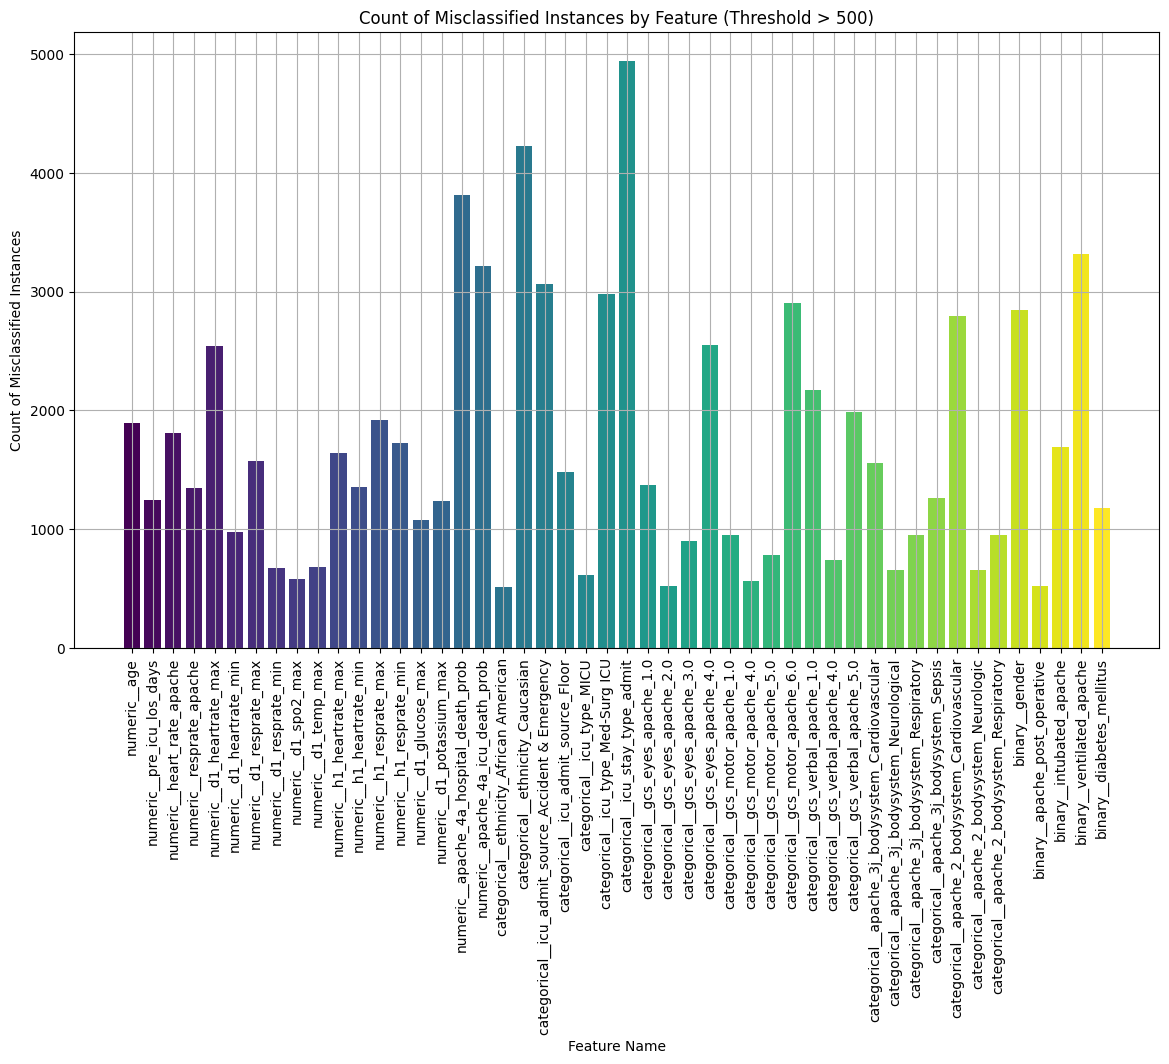

Examples for cases of misclassified samples:
Sample 0: True Label = 1, Predicted Label = 0
Features: numeric__age
Sample 1: True Label = 1, Predicted Label = 0
Features: numeric__bmi
Sample 2: True Label = 1, Predicted Label = 0
Features: numeric__height
Sample 3: True Label = 1, Predicted Label = 0
Features: numeric__pre_icu_los_days
Sample 4: True Label = 1, Predicted Label = 0
Features: numeric__weight


In [208]:
# initializing parameters
samples_treshold = 500
all_misclassified_indices = []

# Collect misclassified instances
misclassified_indices = np.where(y_train_pred != y_train)[0]

# Analyze features of misclassified instances
misclassified_features = X_train_transformed[misclassified_indices]
misclassified_labels = y_train.iloc[misclassified_indices]
misclassified_predictions = y_train_pred[misclassified_indices]
misclassified_feature_names = new_columns

# Convert the misclassified feature array into sums of misclassified instances per feature
if isinstance(misclassified_features,np.ndarray):
   misclassified_counts = np.sum(misclassified_features, axis=0)
else:
  misclassified_counts = np.sum(misclassified_features.toarray(), axis=0)

# Filter features based on the threshold
selected_misclassified_features = [feature for feature, count in zip(misclassified_feature_names, misclassified_counts) if count > samples_treshold]
selected_misclassified_counts = [count for count in misclassified_counts if count > samples_treshold]

# Create the plot
plt.figure(figsize=(14, 8))  # Adjust the figure size for better visibility of feature names
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_misclassified_features)))  # Generate different colors for each bar

plt.bar(selected_misclassified_features, selected_misclassified_counts, color=colors)

plt.xlabel('Feature Name')
plt.xticks(rotation=90)  # Rotate feature names to make them readable
plt.ylabel('Count of Misclassified Instances')
plt.title('Count of Misclassified Instances by Feature (Threshold > {})'.format(samples_treshold))

# # Add a legend outside the plot area to the right
# plt.legend(misclassified_feature_names, loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()


# Analyze a few misclassified samples
print("Examples for cases of misclassified samples:")
for i in range(min(5, len(misclassified_indices))):
    print(f"Sample {i}: True Label = {misclassified_labels.to_numpy()[i]}, Predicted Label = {misclassified_predictions[i]}")
    print(f"Features: {misclassified_feature_names[i]}")

In [209]:
# Calculate the total misclassified instances per feature
total_misclassified_counts = {feature: count for feature, count in zip(misclassified_feature_names, misclassified_counts)}

# Sort features by their misclassification counts in descending order
sorted_misclassified_features = sorted(total_misclassified_counts.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 misclassified features
top_10_misclassified_features = sorted_misclassified_features[:10]

# Print the top 10 features with the most errors found, alongside their error counts
print("Top 10 Features with Most Misclassifications:")
for feature, count in top_10_misclassified_features:
    print(f"{feature}: {int(count)} errors")

Top 10 Features with Most Misclassifications:
categorical__icu_stay_type_admit: 4938 errors
categorical__ethnicity_Caucasian: 4221 errors
numeric__apache_4a_hospital_death_prob: 3812 errors
binary__ventilated_apache: 3315 errors
numeric__apache_4a_icu_death_prob: 3213 errors
categorical__icu_admit_source_Accident & Emergency: 3066 errors
categorical__icu_type_Med-Surg ICU: 2982 errors
categorical__gcs_motor_apache_6.0: 2900 errors
binary__gender: 2848 errors
categorical__apache_2_bodysystem_Cardiovascular: 2797 errors


First, We explore the errors in our basic model, and invastigate whether there are biased fetures, with a radical amount of mistaken classification, which might derived from measurement disorders or bias.

To do so, initialy we find the idicens of samples that contains classification mistakes after training.

Then, we select the features with more than 500 mistaken samples classification and present a visualization of it.

For each one of the presented features, we can see the relative amount of mistakes.

We'll decided later, relates to feature importance analysis, which feature we should exclude in order to improve our model performance.

Note: we have an approximately 90000 samples, and we will take it into consideration in the decision process.

# Detect problematic Samples- with high frequency of missclassification

In [210]:
# Define parameters
threshold = 6 # threshold for high-mistake samples
cv_folds = 10  # Define the number of folds for cross-validation

# Define model
model = xgb.XGBClassifier(random_state=42)

def run_cross_validation_with_error_tracking(model, X, y, cv):
    misclassified_counts = defaultdict(int)
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)

        # Identify misclassified samples
        misclassified = (y_val != y_val_pred)
        misclassified_indices = val_index[misclassified]

        # Count misclassifications
        for idx in misclassified_indices:
            misclassified_counts[idx] += 1

    return misclassified_counts

# Run cross-validation and track errors using the number of folds defined
misclassified_counts = run_cross_validation_with_error_tracking(model, X_train_transformed, y_train, cv_folds)

# Convert the counts to a pandas Series
misclassified_counts_series = pd.Series(misclassified_counts)

# Identify high-mistake samples
high_mistake_samples = misclassified_counts_series[misclassified_counts_series > threshold].index

print(f"Number of high-mistake samples: {len(high_mistake_samples)}")

# Create a mask for filtering out high-mistake samples
mask = np.ones(X_train_transformed.shape[0], dtype=bool)
mask[high_mistake_samples] = False

# Filter the training data
X_train_filtered = X_train_transformed[mask]
y_train_filtered = y_train.iloc[mask]

# Verify the new shapes of the datasets
print(f"Original dataset size: {X_train_transformed.shape[0]}")
print(f"Filtered dataset size: {X_train_filtered.shape[0]}")

Number of high-mistake samples: 0
Original dataset size: 73370
Filtered dataset size: 73370


Here, we are trying to track in a corss-validation process of the train set, whether there are repetitive misclassification for some samples. Samples that are frequently misclassified are identified and filtered out from the training data based on a specified threshold. Than, we compare between the original dataset size and the filtered dataset size, to examine the change.

We did not discovered problematic samples.

# Exploring feature importance


Since we have a large number of features, we want to get a "feeling" regarding their relative contribution to the model. This will help us to understand if we have some consistent fields with significant impact on our model.

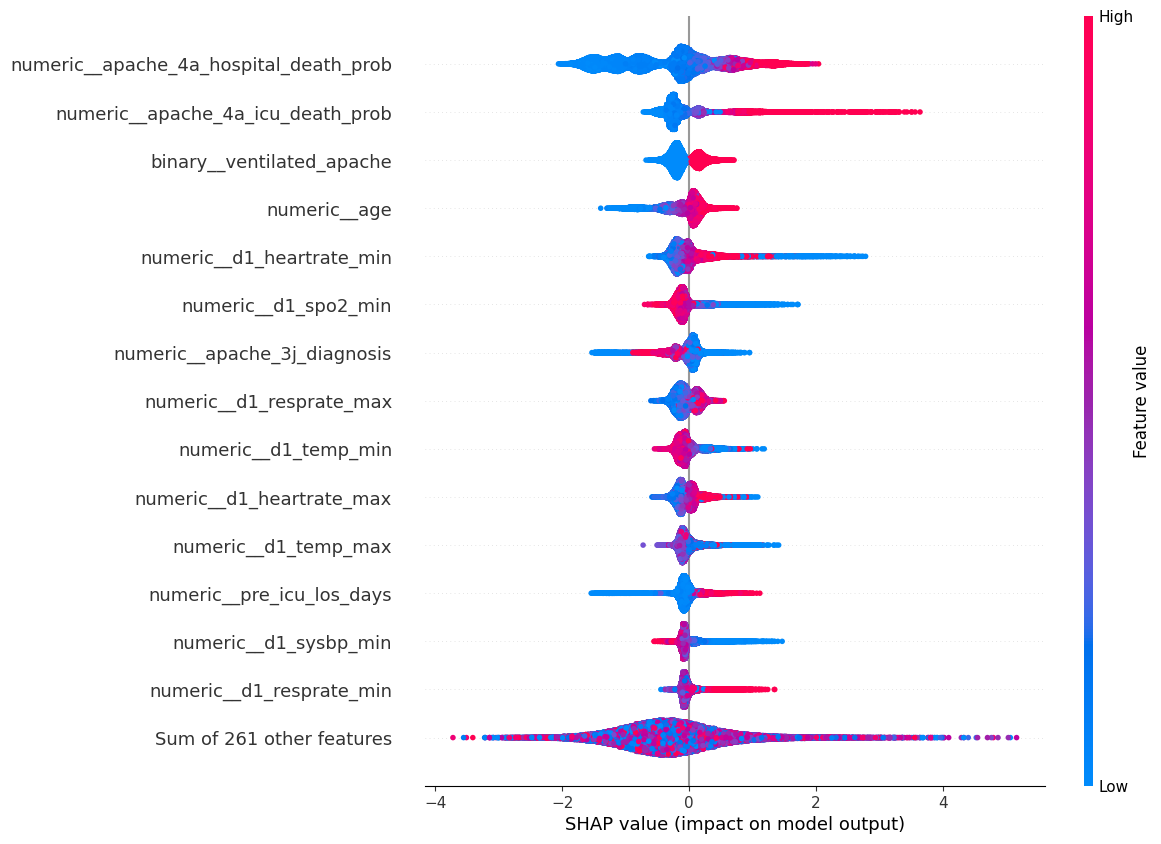

In [211]:
# TreeExplainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_train_transformed)
# Generate the SHAP Explanation object necessary for plotting
shap_explanation = shap.Explanation(values=shap_values,
                                    base_values=explainer.expected_value,
                                    data=X_train_transformed,
                                    feature_names=new_columns)

shap.plots.beeswarm(shap_explanation, max_display=15, plot_size=(10, 10))

Here we can see which features contribute the most to the hospital death prediction.

Red indicate a high value of the feature, purple indicates a mediume value and blue a low value. Each point represent one sample. Right direction on the x axis, indicates classification of the case group.

We can conclde a few points:

1. The feature "numeric_apache_4a_hospital_death_prob" significantly influences the model, having previously also demonstrated the highest correlation with the target feature (correlation of 0.31).

2.  Similarly, the feature "numeric_apache_4a_icu_death_prob" also merits further examination due to its notable correlation of 0.28 with the target.

3. These two highly impactful features("numeric_apache_4a_hospital_death_prob" and "numeric_apache_4a_icu_death_prob") , also account for over 3,000 misclassifications each, as identified in our error analysis.

4. As we seen in the pre-process visualizations, the age has an important impact on the model performance, and the chance to survive (control) is increased as the age values are lower.

5. Besides 14 important features presented, there are 261 with less impact by their self, but still might has a strong combine impact.

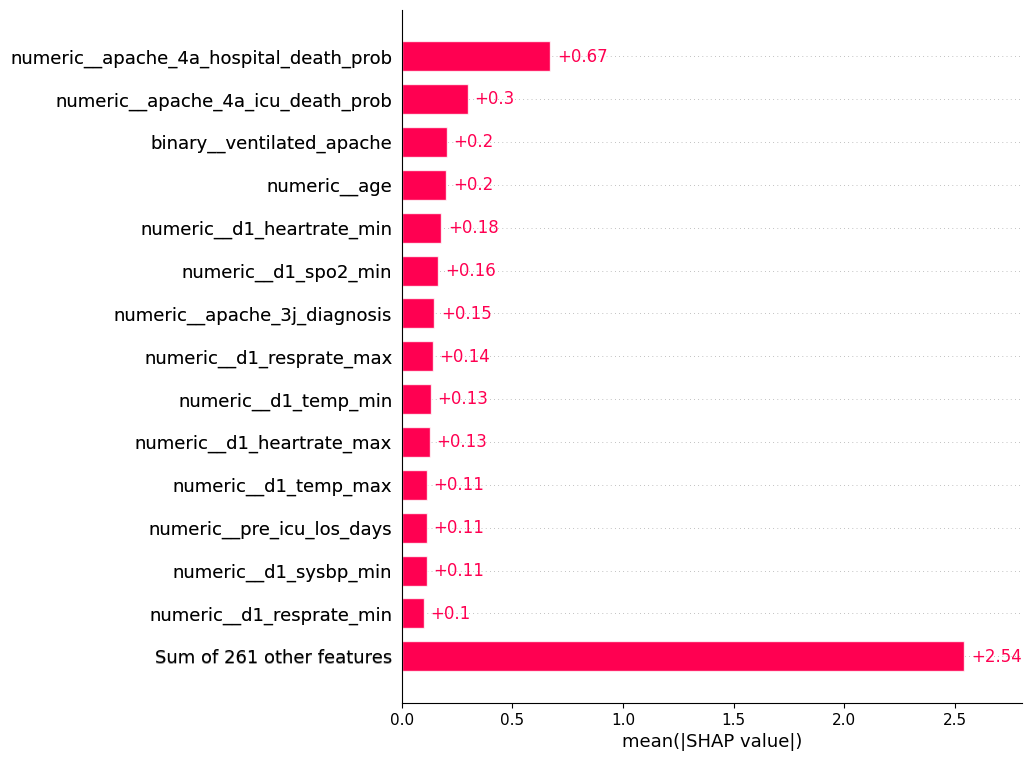

In [212]:
shap.plots.bar(shap_explanation, max_display=15)  # Display top 15 features

Here we can see anothe comfortable presntation, for one sample. We can see an overlaping of the most important feature- emphasyse it impact on the model performance should been examined.

# 3- Feature selection: by importance and error analyzing

We will attempt to remove the features identified as having the most classification errors, except for those that significantly impact model performance.

The features we will examine for removal are:

categorical__icu_stay_type_admit: 4923 errors

categorical__ethnicity_Caucasian: 4218 errors

categorical__icu_admit_source_Accident & Emergency: 3062 errors

categorical__icu_type_Med-Surg ICU: 2973 errors

categorical__gcs_motor_apache_6.0: 2872 errors

categorical__apache_2_bodysystem_Cardiovascular: 2788 errors



In [213]:
# Define parameters
num_top_feature = 14
features_to_drop = ["categorical__icu_stay_type_admit",
                    "categorical__ethnicity_Caucasian",
                    "categorical__icu_admit_source_Accident & Emergency",
                    "categorical__icu_type_Med-Surg ICU",
                    "categorical__gcs_motor_apache_6.0",
                    "categorical__apache_2_bodysystem_Cardiovascular"]

In [214]:
# Calculate the mean absolute SHAP values for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({'Feature': new_columns, 'SHAP Importance': shap_importance})

# Sort features by SHAP importance and select the top 10
top_features_df = importance_df.sort_values(by='SHAP Importance', ascending=False).head(num_top_feature)

# Drop suspected columns
top_features_df = top_features_df[~top_features_df['Feature'].isin(features_to_drop)]

# Select columns based on top features for the transformed datasets
X_train_transformed_top = X_train_transformed[:, top_features_df.index]
X_test_transformed_top = X_test_transformed[:, top_features_df.index]

print("Features remaining in the model:")
print(top_features_df)
print(X_train_transformed_top.shape)
print(X_test_transformed_top.shape)

Features remaining in the model:
                                    Feature  SHAP Importance
53   numeric__apache_4a_hospital_death_prob         0.670323
54        numeric__apache_4a_icu_death_prob         0.297972
266               binary__ventilated_apache         0.202010
0                              numeric__age         0.200846
16                numeric__d1_heartrate_min         0.179089
24                     numeric__d1_spo2_min         0.164418
6              numeric__apache_3j_diagnosis         0.147389
21                 numeric__d1_resprate_max         0.140340
30                     numeric__d1_temp_min         0.131166
15                numeric__d1_heartrate_max         0.127619
29                     numeric__d1_temp_max         0.113710
3                 numeric__pre_icu_los_days         0.112770
26                    numeric__d1_sysbp_min         0.112256
22                 numeric__d1_resprate_min         0.098590
(73370, 14)
(18343, 14)


Trying to impply the model on the selective features

In [215]:
# Defining model
model = xgb.XGBClassifier(random_state=42)

# Perform 10-fold cross-validation using only the top 10 features
results_feature_selection = cross_validate(model, X_train_transformed_top, y_train, cv=cv, scoring=scoring, return_estimator=True)

# Evaluate and print the cross-validation results
evaluate_results(results_feature_selection)

# Retrieve the best model from the results
best_model = get_the_best_model(results_feature_selection)

Cross-validation results:
Accuracy : 0.9253 (+/- 0.0017)
Precision : 0.6378 (+/- 0.0185)
Recall : 0.3085 (+/- 0.0176)
F1 : 0.4156 (+/- 0.0188)
Roc_auc : 0.8758 (+/- 0.0061)
Explained_variance : 0.0768 (+/- 0.0212)


We got a similar scores, meaning we can perform approximitaly scores using the selective features compared to the initial big amount of features.

# 4- Dimensionality Reduction



Alongside testing the model with feature selection informed by error analysis and feature importance, we are also addressing dimensionality reduction techniques to see if they enhance the model's performance.

Truncated Singular Value Decomposition (SVD) is a dimensionality reduction technique that excels in processing sparse, high-dimensional, and skewed data.

This method is derived from singular value decomposition and is particularly adept at maintaining the essential structure and most of the variance of the input data. By capturing the most significant patterns and relationships through the largest singular values and their corresponding singular vectors, SVD effectively reduces the dimensionality of data to a more manageable and analytically efficient form.

After finding that Principal Component Analysis (PCA) was not suitable due to the sparse nature of our dataset, we opted for Truncated SVD.

Unlike PCA, which can struggle with data sparsity, SVD does not require the computation of the covariance matrix and therefore handles sparse datasets more effectively, providing a robust alternative for feature reduction in our analysis.

Cumulative Explained Variance: [0.17698616 0.31697513 0.4189387  0.50909045 0.58895529 0.66505473
 0.72891653 0.79188384 0.85034178 0.90235675 0.94809757 0.97801726
 0.99115045]


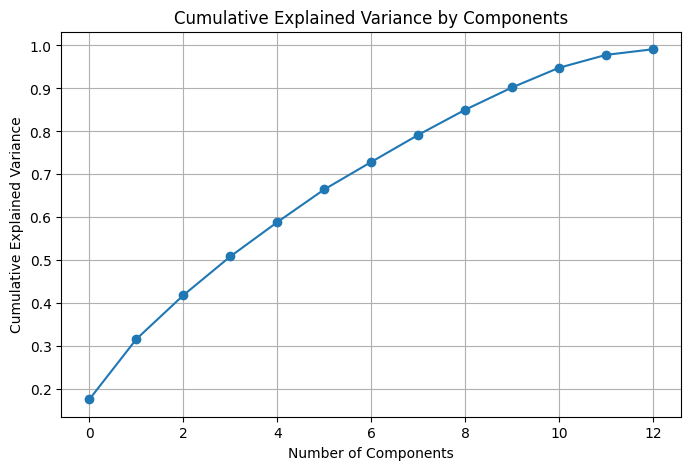

Number of components capturing at least 90% variance: 10


In [216]:
# Applying Truncated SVD
svd = TruncatedSVD(n_components=X_train_transformed_top.shape[1] - 1)
X_train_svd = svd.fit_transform(X_train_transformed_top)

# Explained variance ratio
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Components')
plt.grid(True)
plt.show()

# Selecting the number of components that explain at least 90% of the variance
n_components = np.argmax(cumulative_variance >= 0.90) + 1
print("Number of components capturing at least 90% variance:", n_components)

# Re-applying SVD with optimal number of components
optimal_svd = TruncatedSVD(n_components=n_components)
X_train_svd = optimal_svd.fit_transform(X_train_transformed_top)
X_test_svd = optimal_svd.transform(X_test_transformed_top)

In [217]:
# Evaluate the model's predictive results in a 10 fold cross-validation process after applying feature selection

# Defining model
model = xgb.XGBClassifier(random_state=42)

# Perform 10-fold cross-validation using only the top 10 features
results_svd = cross_validate(model, X_train_svd, y_train, cv=cv, scoring=scoring, return_estimator=True)

# Evaluate and print the cross-validation results
evaluate_results(results_svd)

# # Retrieve the best model from the results
# best_model = get_the_best_model(results_svd)

Cross-validation results:
Accuracy : 0.9225 (+/- 0.0020)
Precision : 0.6095 (+/- 0.0259)
Recall : 0.2832 (+/- 0.0194)
F1 : 0.3864 (+/- 0.0208)
Roc_auc : 0.8605 (+/- 0.0067)
Explained_variance : 0.0437 (+/- 0.0258)


We can see the performance using the selective features is better than using the dimention reduction for this case.

We will continue the analysis using the selected features.

# 5- Data Imbalance


Another aspect of the data should be handeled is the data imbalance. As shown earlier in the report, the datased is highly imbalanced. There are many more patients who did not experience in-hospital death than cases of in-hospital death.

We can check if the model indid predict an imbalanced results:

In [218]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Generate cross-validated predictions for the training set using the transformed features
y_pred = cross_val_predict(model, X_train_transformed_top, y_train, cv=cv)

# Print classification report to see the performance on each class
print("Classification Report:")
print(classification_report(y_train, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     67042
           1       0.64      0.31      0.42      6328

    accuracy                           0.93     73370
   macro avg       0.79      0.65      0.69     73370
weighted avg       0.91      0.93      0.91     73370



As we see the model has shown better performance for “0” label than “1” due to an unbalanced dataset.

This class imbalance can lead to biased models that favor the majority class and perform poorly in predicting the minority class.

We use SMOTE to address this problem, as is it a popular technique used to address class imbalance by oversampling the minority class.

In addition we will add in the following steps the hyper-parameter: 'scale pos weight' that can give more importance to the minority class.

In [219]:
# Defining model
model = xgb.XGBClassifier(random_state=42)

# applying SMOTE
smote = SMOTE(random_state=42)

# Define pipeline with SMOTE and the model
pipeline = ImbPipeline(steps=[('smote', smote), ('model', model)])

# Perform 10-fold cross-validation using the pipeline
results_feature_selection = cross_validate(pipeline, X_train_transformed_top, y_train, cv=cv, scoring=scoring, return_train_score=True)

# Evaluate and print the cross-validation results
evaluate_results(results_feature_selection)




Cross-validation results:
Accuracy : 0.9232 (+/- 0.0033)
Precision : 0.5867 (+/- 0.0302)
Recall : 0.3685 (+/- 0.0292)
F1 : 0.4523 (+/- 0.0289)
Roc_auc : 0.8759 (+/- 0.0074)
Explained_variance : 0.0381 (+/- 0.0419)


By balancing the dataset, we decrese the chances for biased classification due to one majority class.

However, we can see the model performance have not improved by this process.

Though, we are handling this to ensure that the learning process considers all classes more equitably, not favoring features that are more predictive of the majority class.

# 6- Trying another models








When dealing with highly imbalanced, skewed, and high-dimensional clinical data, our XGBoost model is a strong choice due to its ability to handle complex datasets effectively.

However, we'll explore another models that might yield better results.

Logistic Regression

In [220]:
# Defining model
logistic_model = LogisticRegression(random_state=42)

# Perform 10-fold cross-validation using only the top 10 features
results_feature_selection_logistic = cross_validate(logistic_model, X_train_transformed_top, y_train, cv=cv, scoring=scoring, return_estimator=True)

# Evaluate and print the cross-validation results
evaluate_results(results_feature_selection_logistic)

# Retrieve the best model from the results
best_model = get_the_best_model(results_feature_selection_logistic)

Cross-validation results:
Accuracy : 0.9235 (+/- 0.0022)
Precision : 0.6631 (+/- 0.0406)
Recall : 0.2312 (+/- 0.0180)
F1 : 0.3425 (+/- 0.0229)
Roc_auc : 0.8420 (+/- 0.0106)
Explained_variance : 0.0697 (+/- 0.0280)


The Logistic Regression's performance is lower.

Gradient Boosting Machine (GBM)


In [221]:
# Defining the Gradient Boosting Machine model
gbm_model = GradientBoostingClassifier(n_estimators=50, random_state=42)

# Perform 10-fold cross-validation using the top features
results_gbm = cross_validate(gbm_model, X_train_transformed_top, y_train, cv=cv, scoring=scoring, return_estimator=True)

# Evaluate and print the cross-validation results for GBM
print("Gradient Boosting Machine Evaluation:")
evaluate_results(results_gbm)

# Retrieve the best model from the results for GBM
best_gbm_model = get_the_best_model(results_gbm)

Gradient Boosting Machine Evaluation:
Cross-validation results:
Accuracy : 0.9267 (+/- 0.0019)
Precision : 0.6820 (+/- 0.0297)
Recall : 0.2816 (+/- 0.0191)
F1 : 0.3982 (+/- 0.0208)
Roc_auc : 0.8775 (+/- 0.0053)
Explained_variance : 0.1021 (+/- 0.0248)


The results are approximatly similar.

- Another tree model- adaboost model

In [222]:
# Defining model
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_estimator = base_model, n_estimators=50)

# Perform 10-fold cross-validation using only the top 10 features
results_feature_selection_adaboost = cross_validate(adaboost_model, X_train_transformed_top, y_train, cv=cv, scoring=scoring, return_estimator=True)

# Evaluate and print the cross-validation results
evaluate_results(results_feature_selection_adaboost)

# Retrieve the best model from the results
best_model = get_the_best_model(results_feature_selection_adaboost)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning:

`base_estimator` was renamed to `estim

Cross-validation results:
Accuracy : 0.9253 (+/- 0.0023)
Precision : 0.6435 (+/- 0.0265)
Recall : 0.3006 (+/- 0.0209)
F1 : 0.4095 (+/- 0.0230)
Roc_auc : 0.8770 (+/- 0.0059)
Explained_variance : 0.0791 (+/- 0.0282)


We can see a simple logistic regression also success in performing a quite not bad results. But, it is still not good as the xgboost model. The GBM and adaboost models performance is similar to the performance of the xgboost. We will continue to work with the xgboost one.

# 7- Hyper parameter tuning + performing a new improved model

Extreme Gradient Boosting (XGBoost) is an efficient implementation of the gradient boosting algorithm, which builds multiple decision trees sequentially. Each tree is trained to correct the errors made by the previous trees, and gradually improving the overall model's performance.

The model has variety of hyper-parameter that can adjust corresponding to reqierments and affect the model performance.
We chose to optimize the following parameters:
1. max_depth: specifies the maximum depth of each decision tree in the ensemble. Deeper trees can capture more complex patterns in the data but may also lead to overfitting.
2. Learning Rate: controls the contribution of each tree to the ensemble. A lower learning rate requires more trees to achieve the same level of model performance but can improve generalization.
3. n_estimators: This hyperparameter determines the number of trees to be built. A higher number of boosting rounds can improve the model's performance, but it also increases the risk of overfitting.
4. Subsample: This hyperparameter specifies the fraction of training data to be used for each boosting round. It can help prevent overfitting by introducing randomness into the training process.
5. colsample_bytree: controls the fraction of features (columns) to be randomly sampled for each tree. It helps introduce diversity into the ensemble and can reduce overfitting.
6. Gamma: Specifies the minimum reduction in the loss function required to make a further partition on a leaf node of the tree. It acts as regularization by controlling the tree's growth and can prevent overfitting.
7. min_child_weight: Specifies the minimum sum of instance weight (hessian) needed in a child (leaf) node. It helps control the tree's complexity and can prevent overfitting by requiring a minimum amount of data in each leaf node.


This cell performs extensive hyperparameter tuning and may take a long time to run. Type 'skip' to load the saved model and results, or type anything else to run the tuning: skip
Model and results loaded successfully.

Evaluating the model on the training set:
Cross-validation results:
Accuracy : 0.9276 (+/- 0.0020)
Precision : 0.6809 (+/- 0.0347)
Recall : 0.3027 (+/- 0.0174)
F1 : 0.4186 (+/- 0.0184)
Roc_auc : 0.8869 (+/- 0.0064)
Explained_variance : 0.1097 (+/- 0.0283)

Evaluating the model on the test set:
ROC AUC test: 0.8876


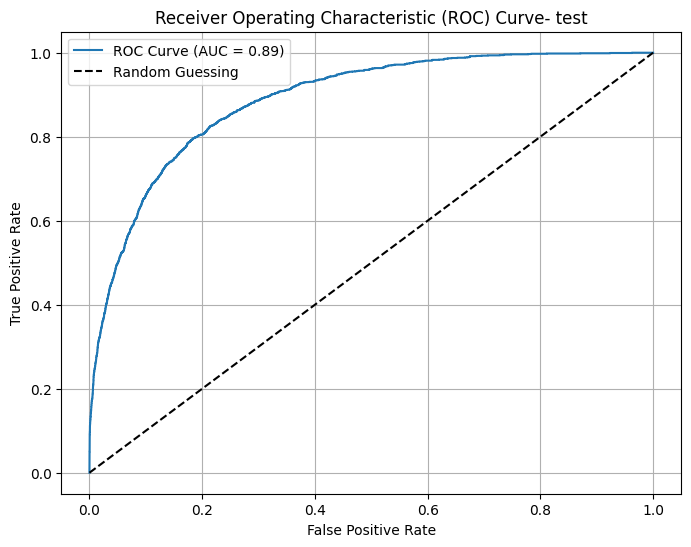

In [223]:
# Asking the user whether to run this cell or to skip it
run_cell = input("This cell performs extensive hyperparameter tuning and may take a long time to run. Type 'skip' to load the saved model and results, or type anything else to run the tuning: ")

if run_cell.lower() == 'skip':
    # Load the saved model and results if they exist
    if os.path.exists("saved_model.pkl") and os.path.exists("saved_results.pkl"):
        best_model = joblib.load("saved_model.pkl")
        results = joblib.load("saved_results.pkl")
        print("Model and results loaded successfully.")
    else:
        print("Running the tuning process.")
        # Place the full hyperparameter tuning code here as well if the files are not found
else:
    # Define model
    model = xgb.XGBClassifier(random_state=42, reg_lambda=1, reg_alpha=0.5)

    # Define parameters for hyper-parameter tuning
    param_grid = {
        # 'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.05],
        # 'scale_pos_weight': [1, 10, 20],
        # 'lambda': [1, 1.5, 2],
        # 'alpha': [0, 0.1, 0.5],
        # 'gamma': [0, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        # 'min_child_weight': [1, 3, 5]
    }

    # Define the cross-validation strategy for hyper-parameter tuning
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_transformed_top, y_train)

    # Get the best hyperparameters and the corresponding model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    print("Best Hyperparameters:", best_params)

    # Save the model and results
    joblib.dump(best_model, "saved_model.pkl")
    joblib.dump(grid_search, "saved_results.pkl")
    print("Model and tuning results have been saved.")

# Continue with the evaluation using the best_model
print("\nEvaluating the model on the training set:")
results, y_train_pred_proba, y_train_pred = run_10_cross_validation(best_model, X_train_transformed_top, y_train, scoring)
evaluate_results(results)

# Predictions on the test set
y_test_pred_proba = best_model.predict_proba(X_test_transformed_top)[:, 1]
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

# Evaluate the model on the test set and plot the ROC curve
print("\nEvaluating the model on the test set:")
plot_roc_curve_test(y_test, y_test_pred_proba)

Due to memory considerations, derived from our big amount of samples, we decided to use descrete values for the optimizing. Still, we eventialy could not optimaized the whole hyper-parameters alltogether as we aimed to. We did try to optimize different hyper-parameters seperatly to examine their affect.

We can see that the model's performances still remains approximately the same. But during our process, we could have handeled some other aspects of the model, such as making share it is reliabale, more balanced, and less biased to potential misses of important diagnosis.

# Model explanability

This cell calculates SHAP values which can be computationally intensive. Type 'skip' to load saved SHAP values, or type anything else to run the calculation: skip
SHAP values loaded successfully.


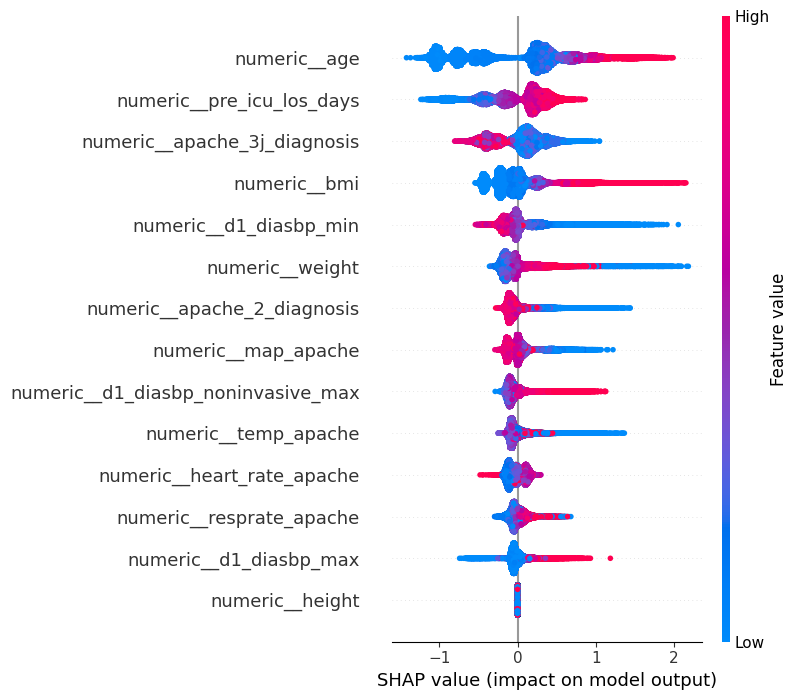

In [224]:
# Asking the user whether to run this cell or to skip it
run_cell = input("This cell calculates SHAP values which can be computationally intensive. Type 'skip' to load saved SHAP values, or type anything else to run the calculation: ")

if run_cell.lower() == 'skip':
    # Load the saved SHAP values if they exist
    if os.path.exists("saved_shap_values.npy"):
        # Convert to dense if X_train_transformed_top is sparse
        X_train_dense = X_train_transformed_top.toarray()
        shap_values = np.load("saved_shap_values.npy")
        print("SHAP values loaded successfully.")
    else:
        print("Running the SHAP calculations.")
        # Convert to dense if X_train_transformed_top is sparse
        X_train_dense = X_train_transformed_top.toarray()
        explainer = shap.Explainer(best_model, X_train_dense)
        shap_values = explainer.shap_values(X_train_dense)
        np.save("saved_shap_values.npy", shap_values)  # Save SHAP values to a file
else:
    # Convert to dense if X_train_transformed_top is sparse
    X_train_dense = X_train_transformed_top.toarray()
    explainer = shap.Explainer(best_model, X_train_dense)
    shap_values = explainer.shap_values(X_train_dense)
    np.save("saved_shap_values.npy", shap_values)  # Save SHAP values to a file

# Generate a summary plot of the SHAP values
shap.summary_plot(shap_values, X_train_dense, feature_names=new_columns)

We can see that the most contributing features differ from those in the initial basic pipeline.
This can point to the modifications in preprocessing or the introduction of new variables during feature engineering.
It can be explained by the changes in the underlying relationships between features and the target variable as the model complexity increased or as a result of different handling of data imbalances and outliers, all of which can significantly alter feature importance rankings.


# Discussion and final thoughts

In this project, we tackled a high-dimensional dataset characterized by significant computational demands and complexity.

The focus was on intelligent feature selection and error analyzing in the attempt to improve the model performance.

 Throughout the model development phase, we engaged in an iterative process involving extensive experimentation with various standard methodologies that, upon application, proved unsuitable for our specific dataset. This often resulted in models that were either underperforming or overly optimistic, suggesting significant overfitting issues.

To address these challenges, we conducted extensive research to refine our strategies and develop an optimized pipeline aimed at enhancing the model's robustness— a critical factor considering the extensive set of features

Key strategies employed included:

1. Strategic Feature Selection: Focused on leveraging features that substantially contribute to model accuracy.

2. Error Management: Systematic identification and correction of prediction errors.

3. Adaptive Outlier Management: Tailored specifically for clinical contexts to preserve vital extreme data points essential for accurate predictions.

4. Balancing Techniques: Application of appropriate methods to address the considerable class imbalance in the dataset.

Despite the progress made, there remains substantial scope for further learning. As mentioned, we aimed to handle both the data and model correctly, as guided by the literature. Although we did not achieve the desired improvement in model results, the finalized pipeline represents a significant step towards achieving a reliable model that enhances predictive accuracy and generalizability.